# LAB3 QIC

In [1]:
!pip install qiskit qiskit-aer seaborn numpy matplotlib

  Obtaining dependency information for qiskit from https://files.pythonhosted.org/packages/d9/06/43b704baf41e43abcc683f84a36a9ee5e02cffc32bc2f55f9ef304ce785d/qiskit-0.44.3-py3-none-any.whl.metadata
  Obtaining dependency information for qiskit-aer from https://files.pythonhosted.org/packages/6f/18/9e101a2fcdd8c2738ee4bb0d31ee1822871809a29ffbea4870e69e1ff2d1/qiskit_aer-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for qiskit-terra==0.25.3 from https://files.pythonhosted.org/packages/8e/aa/5d125872084fa44b8febbeaad92f1e2dc1c1395b9d1bb9de1d3570009e6b/qiskit_terra-0.25.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for rustworkx>=0.13.0 from https://files.pythonhosted.org/pac

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [3]:
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector,plot_bloch_multivector
import numpy as np

## Deutsch-Jozsa Algorithm

Given a hidden Boolean function $f(\{x_0,x_1,\dots,x_{n-1}\}) \rightarrow $ **0 or 1** where $x_i$ is 0 or 1. The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all 's or all 's for any input, while a balanced function returns 's for exactly half of all inputs and 's for the other half. Our task is to determine whether the given function is balanced or constant.

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$ , provided we have the function $f$ implemented as a quantum oracle, which maps the state $\ket{x}\ket{y}$ to $\ket{x}\ket{y \oplus f(x)}$ , where $\oplus$ is addition modulo .

### Steps of the algorithm

1. Prepare 2 quantum registers. The first is an **n**-qubit register initialized to $\ket{0}$, and the second is a 1-qubit register initialized to $\ket{1}$: $\ket{\psi_0} = \ket{0}^{\otimes n}\ket{1}$
2. Apply Hadamard gate to each qubit: $\ket{\psi_1}=\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^{n}-1}\ket{x}(\ket{0}-\ket{1})$
3. Apply the quantum oracle  $\ket{x}\ket{y} \rightarrow \ket{x}\ket{y \oplus f(x)}$ such that $\ket{\psi_2}=\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^{n}-1}(-1)^{f(x)}\ket{x}(\ket{0}-\ket{1})$
4. Apply Hadamard gate to each qubit in the first register such that: $\ket{\psi_3} = \frac{1}{2^n}\sum_{y=0}^{2^{n}-1}\left[\sum_{x=0}^{2^{n}-1}(-1)^{f(x)}(-1)^{xy}\right]\ket{y}$
5. Measure the first register. The probability of measuring $\ket{0}^{\otimes n} = |\frac{1}{2^{n}}\sum_{x=0}^{2^{n}-1}(-1)^{f(x)}|^2$ which evaluates to 1 if the function is constant and 0 if it is balanced.

#### Example

In [36]:
# set the length of the first qregister
n = 3

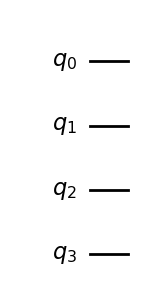

In [37]:
# Constant oracle

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
const_oracle.draw(output="mpl")

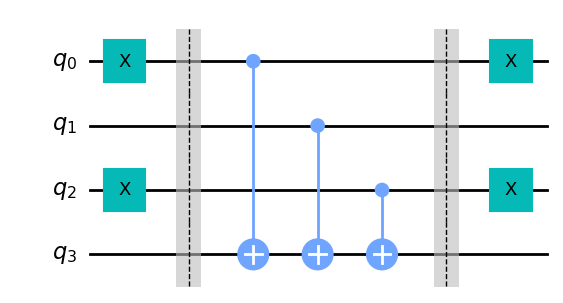

In [29]:
# Balanced oracle
balanced_oracle = QuantumCircuit(n+1)
output = [1,0,1]#[np.random.randint(2) for _ in range(0,n)]
for i in range(0, len(output)):
    if output[i] == 1:
        balanced_oracle.x(i)

balanced_oracle.barrier()

for qubit in range(n):
    balanced_oracle.cx(qubit,n)

balanced_oracle.barrier()

for i in range(0, len(output)):
    if output[i] == 1:
        balanced_oracle.x(i)

balanced_oracle.draw(output="mpl")

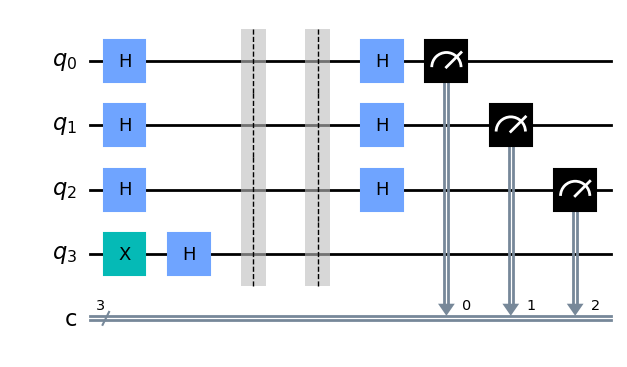

In [38]:
dj_circuit = QuantumCircuit(n+1, n)
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit.barrier()

# Add oracle
dj_circuit = dj_circuit.compose(const_oracle)

dj_circuit.barrier()

#repeat the H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

#measure
for i in range(n):
    dj_circuit.measure(i,i)
dj_circuit.draw(output="mpl")



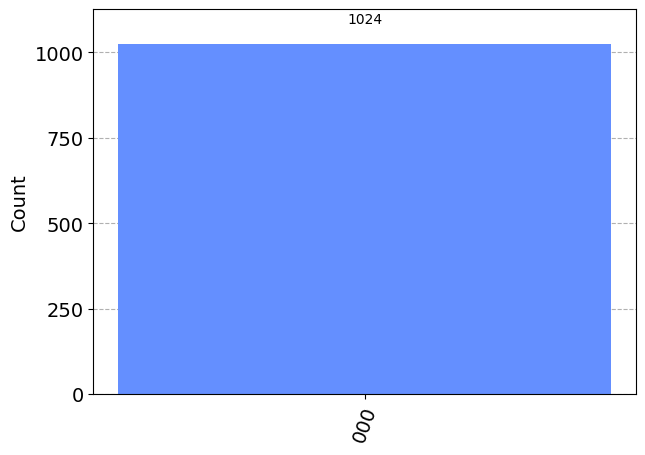

In [39]:
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(dj_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

The results shows that we have a 0% chance of measuring 000, thus, the function is balanced.

#### Generalized Circuit

In [41]:
def dj_oracle(case, n):
    # case is either constant or balanced and n is the size of the input register
    # Create a circuit that has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [42]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

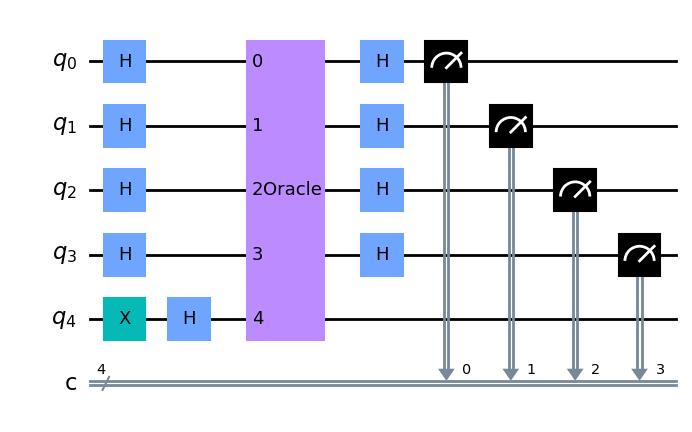

In [43]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw(output="mpl")

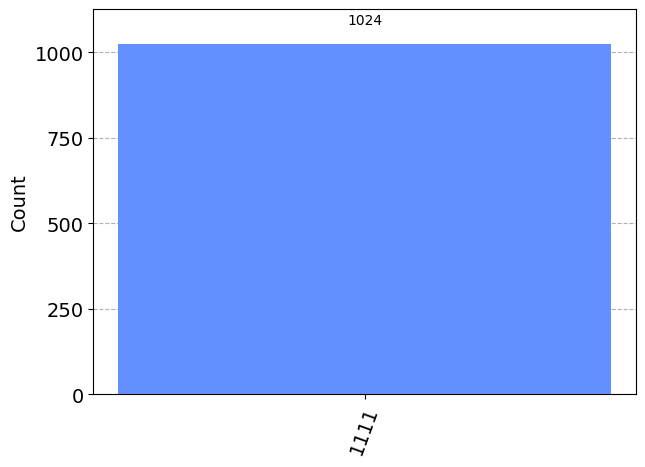

In [44]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

## The Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm can be seen as an extension of Deutsch-Jozsa algorithm. Given a hidden Boolean function $f(\{x_0,x_1,\dots,x_{n-1}\}) \rightarrow $ **0 or 1** where $x_i$ is 0 or 1. Instead of the function being balanced or constant, now the function is guaranteed to return the bitwise product of the input with some string, *s*. Thus, for an input *x*, $f(x) = s \cdot x (mod 2)$ and we are expected to find *s*. The Bernstein-Vazirani oracle looks like this:

![Summary quantum gates](./data/bv_oracle.png)

On a classical computer, to determine the bit string *s* we would need to call the function *n* times.

#### Quantum Solution

The problem can be solved with 100% confidence after only one call to function $f(x)$. The steps are:

1. Initialize the inputs qubits to the state $\ket{0}^{\otimes n}$ state, and the output qubit to $\ket{-1}$
2. Apply Hadamard gates on the input register.
3. Query the oracle.
4. Apply Hadamard gates on the input register.
5. Measure.

### Example

Let's consider an example of $n=2$ qubits and the secret string $s=11$.

1. The register of two qubits is initialized to zero: $\ket{\psi_0} = \ket{00}$.
2. Apply Hadamard gate on to both qubits: $\ket{\psi_1} = \frac{1}{2}\left(\ket{00}+\ket{01}+\ket{10}+\ket{11}\right)$
3. For the string $s=11$ the quantum oracle performs the operation $f_s:\ket{x} \rightarrow (-1)^{x \cdot s}\ket{x} $ such that:
$$
\ket{\psi_2} = \frac{1}{2}\left((-1)^{00 \cdot 11}\ket{00}+(-1)^{01 \cdot 11}\ket{01}+(-1)^{10 \cdot 11}\ket{10}+(-1)^{11 \cdot 11}\ket{11}\right) = \frac{1}{2}\left(\ket{00}-\ket{01}-\ket{10}+\ket{11}\right)
$$
4. Applying Hadamard to both qubits results $\ket{\psi_3} = \ket{11}$
5. Measure to find the secret string $s=11$

#### Notes regarding the Hadamard transformations:

Considering an **n**-qubit state $\ket{\alpha}$ and apply the H-gates we will have the transformation:
$$
H^{\otimes n}: \ket{\alpha} \rightarrow \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^{n}} (-1)^{a \cdot x}\ket{x}
$$

$H\ket{0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$
$H\ket{1} = \frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$

Using the summation notation:
$$
H\ket{\alpha} = \frac{1}{\sqrt{2}}\sum_{x \in \{0,1\}^{n}} (-1)^{a \cdot x}\ket{x}.
$$


For 2 qubits:

$H\ket{00} = \frac{1}{2}(\ket{00}+\ket{01}+\ket{10}+\ket{11})$
$H\ket{01} = \frac{1}{2}(\ket{00}-\ket{01}+\ket{10}-\ket{11})$
$H\ket{10} = \frac{1}{2}(\ket{00}+\ket{01}-\ket{10}-\ket{11})$
$H\ket{11} = \frac{1}{2}(\ket{00}-\ket{01}-\ket{10}+\ket{11})$

thus, the summation notation is:

$$
H^{\otimes 2}: \ket{\alpha} = \frac{1}{2}\sum_{x \in \{0,1\}^{n}} (-1)^{a \cdot x}\ket{x}.
$$


### Qiskit Implementation

In [45]:
n = 3 # number of qubits to represent s
s = "011"

In [54]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)


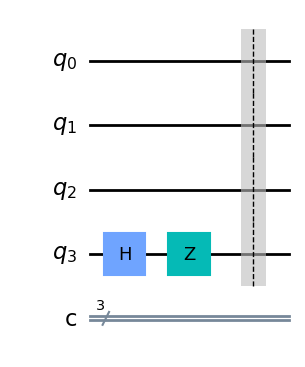

In [55]:
# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)
bv_circuit.barrier()
bv_circuit.draw(output="mpl")

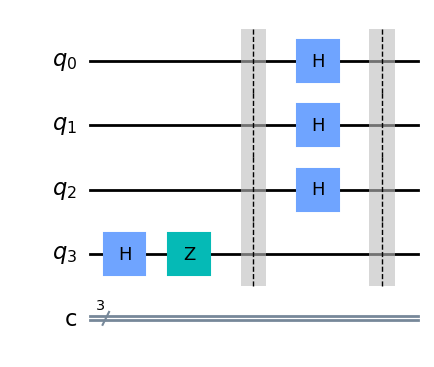

In [56]:
# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()
bv_circuit.draw(output="mpl")

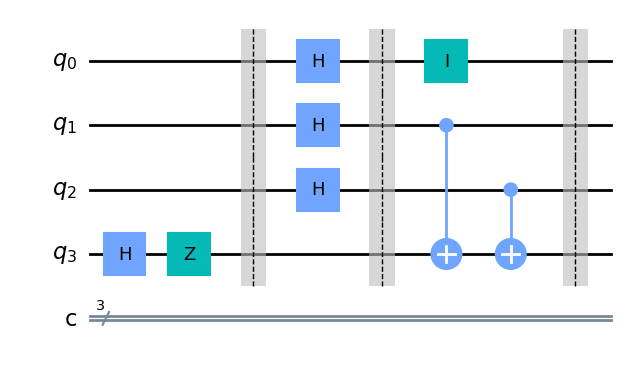

In [57]:
# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()
bv_circuit.draw(output="mpl")

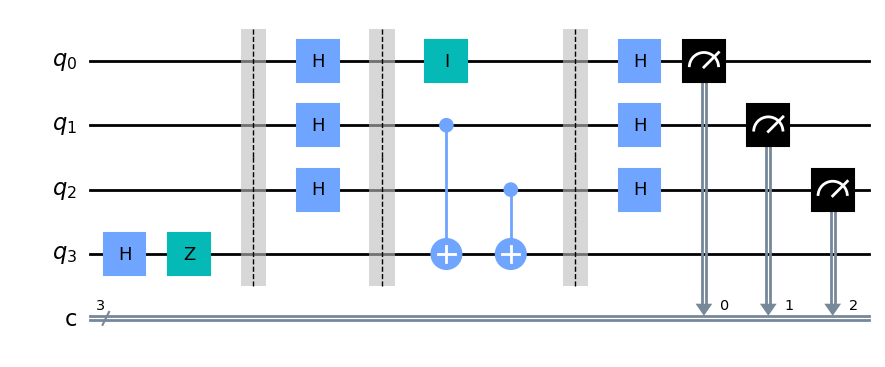

In [58]:
#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw(output="mpl")

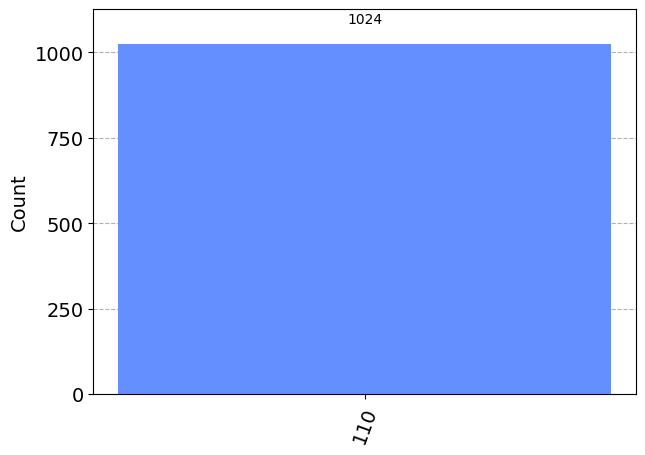

In [59]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

### Generalized circuit

In [60]:
def bv_oracle(s, n):
    oracle_qc = QuantumCircuit(n+1)

    s = s[::-1] #reverse the string
    for q in range(n):
        if s[q] == '0':
            oracle_qc.i(q)
        else:
            oracle_qc.cx(q,n)
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [64]:
def bv_algorithm(s, n):
    bv_circuit = QuantumCircuit(n+1, n)
    bv_circuit.h(n)
    bv_circuit.z(n)
    for i in range(n):
        bv_circuit.h(i)

    oracle_gate = bv_oracle(s,n)
    bv_circuit.append(oracle_gate,range(n+1))
    
    for i in range(n):
        bv_circuit.h(i)

    for i in range(n):
        bv_circuit.measure(i,i)
    
    return bv_circuit

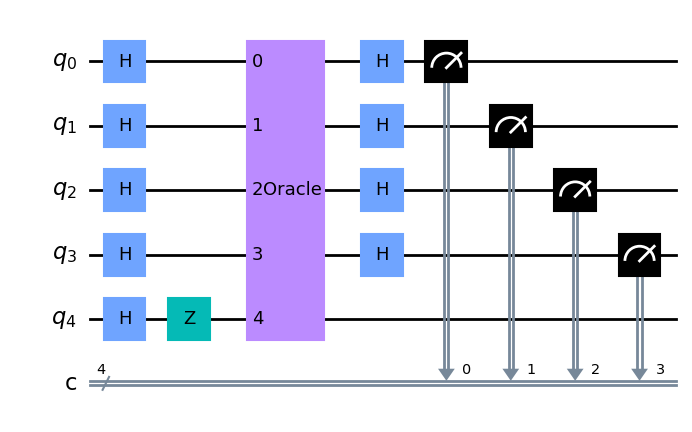

In [74]:
n = 4
bv_circuit = bv_algorithm("1010", n)
bv_circuit.draw(output="mpl")

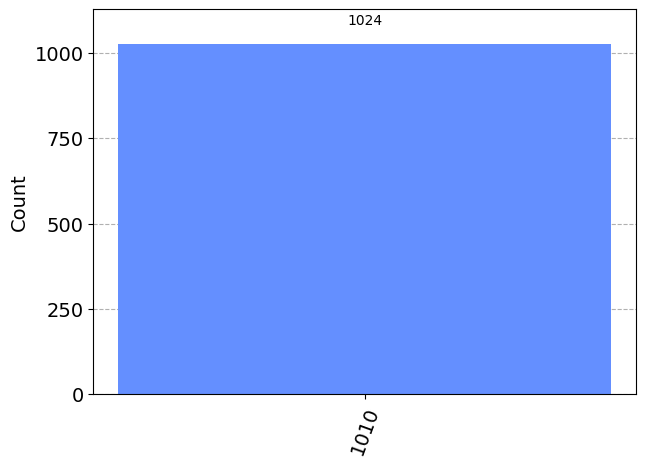

In [75]:
transpiled_bv_circuit = transpile(bv_circuit, aer_sim)
results = aer_sim.run(transpiled_bv_circuit).result()
answer = results.get_counts()
plot_histogram(answer)